In [1]:
import torch
from torch import nn

import numpy as np
from torch.nn import functional as F

import numpy as np
import torch

import matplotlib.pyplot as plt

from utils.helper_functions import load_dm
from utils.arguments import get_parser

from nets.wrapper import *

from pytorch_lightning import Trainer

import json

from sklearn.metrics import confusion_matrix
from nets.metrics import print_cm, metrics_from_cm

In [15]:
plt.rcParams['figure.figsize'] = [16, 4]

In [2]:
import pandas
import os

from nets.wrapper import AutoencoderWrapper, ContrastiveWrapper

In [3]:
model = ContrastiveWrapper.load_from_checkpoint("_tests/clr_UCI-HAR_21-20-19-18-17_4_40_1_bs128_lr0.001_l10_l20_cnn_gap_ts20_cnn_ts_decNone_1/version_1/checkpoints/epoch=18-step=7201-val_re=0.0000.ckpt")

Input shape:  torch.Size([1, 6, 40])
Latent shape:  torch.Size([1, 80])


/home/mbikandi/miniconda3/envs/dev2/lib/python3.10/site-packages/torch/nn/modules/conv.py:306: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1040.)
  return F.conv1d(input, weight, bias, self.stride,


In [4]:
parser = get_parser()
args = parser.parse_args('''
--dataset UCI-HAR --batch_size 128 --window_size 40 --normalize --subjects_for_test 21 20 19 18 17 
--max_epochs 10 --lr 0.001 --training_dir _ae --n_val_subjects 4 --reduce_imbalance --encoder_architecture cnn_ts 
--encoder_features 20 --decoder_architecture cnn_ts_dec --mode clr --same_class --voting 0'''.split())

dm = load_dm(args)

Loaded dataset UCI-HAR with a total of 815614 observations for window size 40
Sampling 48501 (balanced) observations per epoch.
Using 582012 observations for training, 106617 for validation and 143333 for test


In [5]:
tr = Trainer()
tr.test(datamodule=dm, model=model)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Testing DataLoader 0: 100%|██████████| 1120/1120 [00:06<00:00, 161.64it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         test_ap            0.5691895484924316
       test_auroc           0.9417191743850708
       test_fpr95           0.25750407576560974
        test_loss                   0.0
         test_th            -0.9989253282546997
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.0,
  'test_fpr95': 0.25750407576560974,
  'test_th': -0.9989253282546997,
  'test_auroc': 0.9417191743850708,
  'test_ap': 0.5691895484924316}]

In [16]:
wsize = 40
ovlp = 0
diff = (model.rpr[:(-wsize+ovlp), :] * model.rpr[(wsize-ovlp):, :]).sum(-1)

In [17]:
from utils.cp_finder import find_local_maximum_indices

In [18]:
kernel1 = 0.9 ** np.arange(40, 0, -1) 

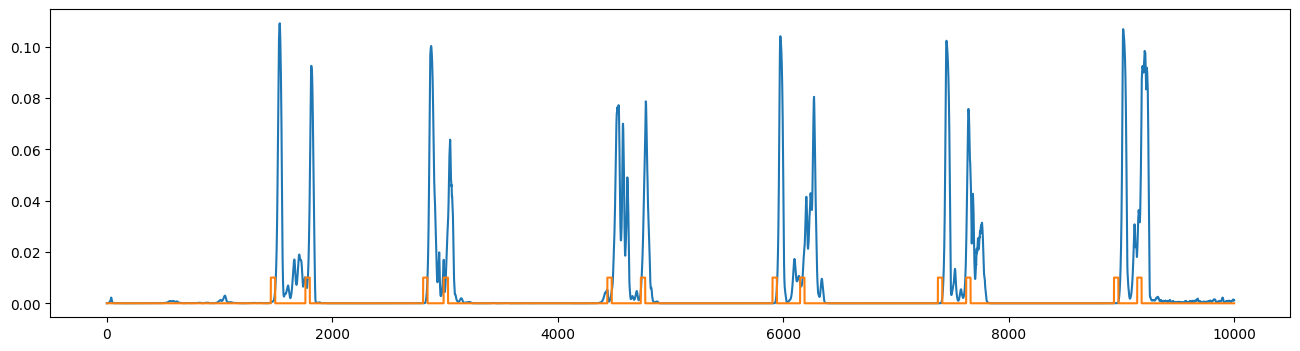

In [19]:
test = np.convolve(-diff+1, kernel1/np.sum(kernel1), "full")[:10000]
plt.plot(np.arange(test.shape[0]), test, np.arange(test.shape[0]), 0.01*model.labels_[:test.shape[0]])

In [20]:
test_ema = np.zeros_like(diff)
diff_ = -diff+1
test_ema[0] = diff_[0]

for i in range(1, test_ema.shape[0]):
    test_ema[i] = (1-0.1)*test_ema[i-1] + 0.1*diff_[i]

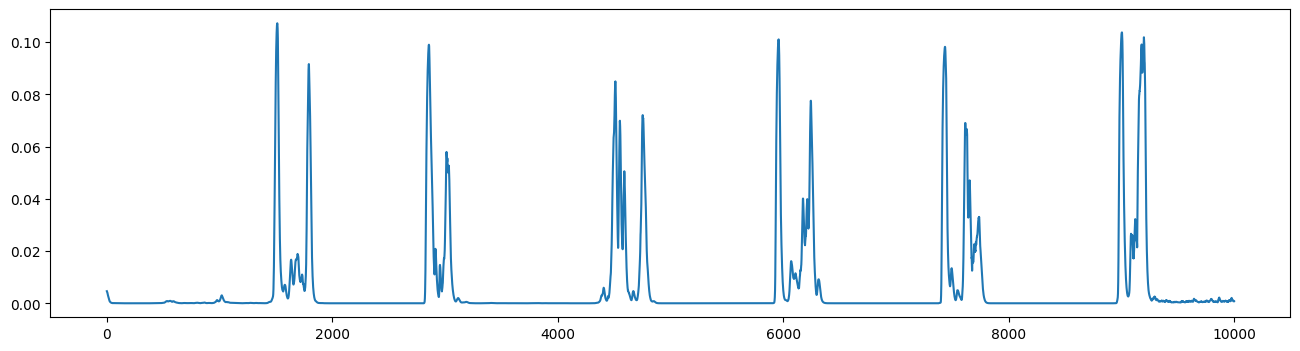

In [21]:
plt.plot(test_ema[:10000])

[1507, 1792, 2852, 3017, 4499, 4754, 5955, 6186, 7429, 7623, 7716, 8997, 9108]


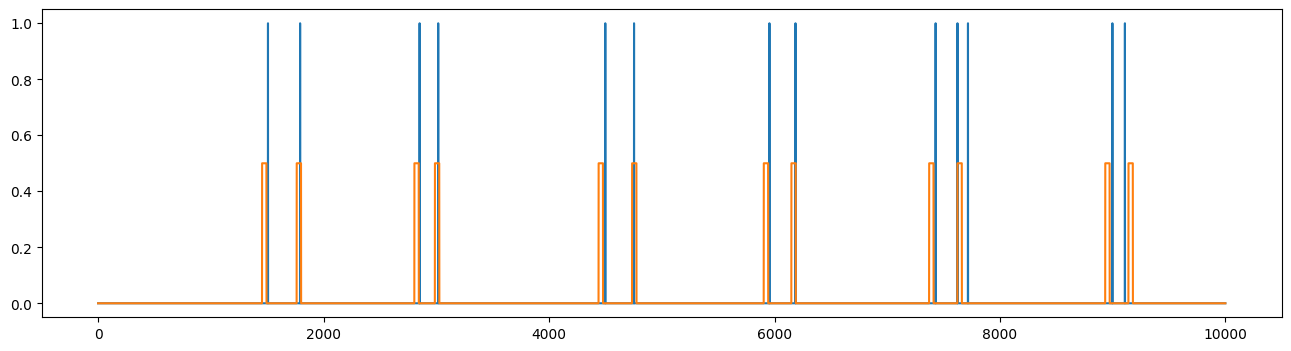

In [22]:
change_points = find_local_maximum_indices(test[:10000], 0.01, warning_time=1, change_time=1, alpha=1)
print(change_points)
arr_ch_po = np.zeros(10000)
arr_ch_po[np.array(change_points)] = 1
plt.plot(np.arange(arr_ch_po.shape[0]), arr_ch_po, np.arange(arr_ch_po.shape[0]), 0.5*model.labels_[:arr_ch_po.shape[0]])